In [4]:
import mlflow
import pandas as pd

def get_parameters_list(data):
    params  = data['params']
    return [params['model'], params['dataset']]


def get_metrics_list(data):
    if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        return [metrics['accuracy'], metrics['f1_score']]
    else:
        return ['-', '-']

In [5]:
# List all existing experiments
all_experiments = mlflow.list_experiments()
exp_data = []
for exp in all_experiments:
    row = [exp.name, exp.artifact_location, exp.lifecycle_stage]
    exp_data.append(row)
exp_frame = pd.DataFrame(exp_data, columns = ['Name', 'Artifacts', 'Status'])
print(exp_frame)

              Name                                          Artifacts  Status
0  DatasetAnalysis  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
1          Default  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
2  ModelComparison  file:///mnt/nfs/home/koshkinam/vector-delirium...  active
3       Prediction  file:///mnt/nfs/home/koshkinam/vector-delirium...  active


In [3]:
# For model training experiment - display last 100 runs with a subset of parameters and metrics
runs = mlflow.list_run_infos('0', max_results=100)
data = []
for r in runs:
    run_data = mlflow.get_run(r.run_id).to_dictionary()['data']
    row = [r.start_time] + get_parameters_list(run_data) + get_metrics_list(run_data)
    data.append(row)
frame = pd.DataFrame(data, columns=['Start time', 'Model', 'Dataset', 'Accuracy', 'F1 Score'])
print('------------------- Model Training Runs ----------------------')
print(frame)

------------------- Model Training Runs ----------------------
       Start time Model   Dataset  Accuracy  F1 Score
0   1636470609315   mlp    gemini  0.678135  0.367164
1   1636470486136   mlp    gemini         -         -
2   1636469705972   mlp    gemini         -         -
3   1636469214940   mlp    gemini         -         -
4   1636418442900   mlp    gemini         -         -
5   1636418378341   mlp    gemini         -         -
6   1636418336218   mlp    gemini         -         -
7   1636418191401   mlp    gemini         -         -
8   1636417898437   mlp    gemini         -         -
9   1636417627586   mlp    gemini         -         -
10  1636416934942   mlp    gemini         -         -
11  1635434580535   mlp    gemini         -         -
12  1634918781255   mlp    gemini   0.67013  0.282486
13  1634915740928   mlp    gemini  0.728733  0.350343
14  1634915064631   mlp    gemini  0.728415  0.349581
15  1634914831011   mlp    gemini  0.728097   0.35129
16  1634914772549  

In [6]:
# Display dataset drift analysis runs

import os
import json

def get_dataset_metrics_list(data):
     if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        #timestamp = data['params']['timestamp']
        drift = 'No' if metrics['dataset_drift']==0 else 'Yes'
        return [drift, metrics['n_features'], metrics['n_drifted_features']]
     else:
        return ['-', '-', '-']

exp = mlflow.get_experiment_by_name('DatasetAnalysis')
runs = mlflow.list_run_infos(exp.experiment_id, max_results=100)
table = []
for r in runs:
    exp_run = mlflow.get_run(r.run_id).to_dictionary()
    path = exp_run['info']['artifact_uri'][6:]
    config_file = os.path.join(path, 'config.json')
    if not os.path.isfile(config_file):
        continue
    with open(config_file) as f:
        data = json.load(f)
        row = [data['input'], data['slice'], data['data_ref'], data['data_eval']]
        row = row + get_dataset_metrics_list(exp_run['data'])
        table.append(row)
frame = pd.DataFrame(table, columns=['Input', 'Slice', 'Ref Slice', 'Eval Slice', 'Drift', 'Feat', 'Drift_Feat'])
print('------------------- Dataset Analysis ----------------------')
print(frame)

------------------- Dataset Analysis ----------------------
                                                Input Slice Ref Slice  \
0                                  ../gemini_data.csv          [2015]   
1                                  ../gemini_data.csv          [2015]   
2                                  ../gemini_data.csv          [2015]   
3                                  ../gemini_data.csv          [2015]   
4                                  ../gemini_data.csv          [2015]   
5                                  ../gemini_data.csv          [2015]   
6                                  ../gemini_data.csv          [2015]   
7                                  ../gemini_data.csv          [2015]   
8                                  ../gemini_data.csv          [2015]   
9                                  ../gemini_data.csv          [2015]   
10                                 ../gemini_data.csv          [2015]   
11                                 ../gemini_data.csv          [

In [7]:
# Display model comparison analysis runs
def get_model_metrics_list(data):
    if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        return [metrics['ref_accuracy'], metrics['test_accuracy'], metrics['ref_f1'], metrics['test_f1']]
    else:
        return ['-', '-', '-']

exp = mlflow.get_experiment_by_name('ModelComparison')
runs = mlflow.list_run_infos(exp.experiment_id, max_results=100)
table = []
for r in runs:
    exp_run = mlflow.get_run(r.run_id).to_dictionary()
    path = exp_run['info']['artifact_uri'][6:]
    config_file = os.path.join(path, 'config.json')
    if not os.path.isfile(config_file):
        continue
    with open(config_file) as f:
        data = json.load(f)
        row = [data['reference'][-20:], data['test'][-20:]]
        row = row + get_model_metrics_list(exp_run['data'])
        table.append(row)
frame = pd.DataFrame(table, columns=['Reference', 'Eval', 'Ref Acc', 'Eval Acc', 'Ref F1 Score', 'Eval F1 Score'])
print('------------------- Model Peformance Comparison  ----------------------')
print(frame)

------------------- Model Peformance Comparison  ----------------------
               Reference                  Eval   Ref Acc  Eval Acc  \
0   hkinam/reference.csv  20-01-01/results.csv  0.679243  0.708020   
1   hkinam/reference.csv  20-02-01/results.csv  0.679243  0.700325   
2   hkinam/reference.csv  20-03-01/results.csv  0.679243  0.676266   
3   hkinam/reference.csv  20-04-01/results.csv  0.679243  0.715552   
4   hkinam/reference.csv  20-05-01/results.csv  0.679243  0.668636   
5   hkinam/reference.csv  20-06-01/results.csv  0.679243  0.676129   
6   hkinam/reference.csv  19-01-01/results.csv  0.679243  0.691828   
7   hkinam/reference.csv  19-02-01/results.csv  0.679243  0.662766   
8   hkinam/reference.csv  19-03-01/results.csv  0.679243  0.652174   
9   hkinam/reference.csv  19-04-01/results.csv  0.679243  0.651077   
10  hkinam/reference.csv  19-05-01/results.csv  0.679243  0.680796   
11  hkinam/reference.csv  19-06-01/results.csv  0.679243  0.687382   
12  hkinam/referen

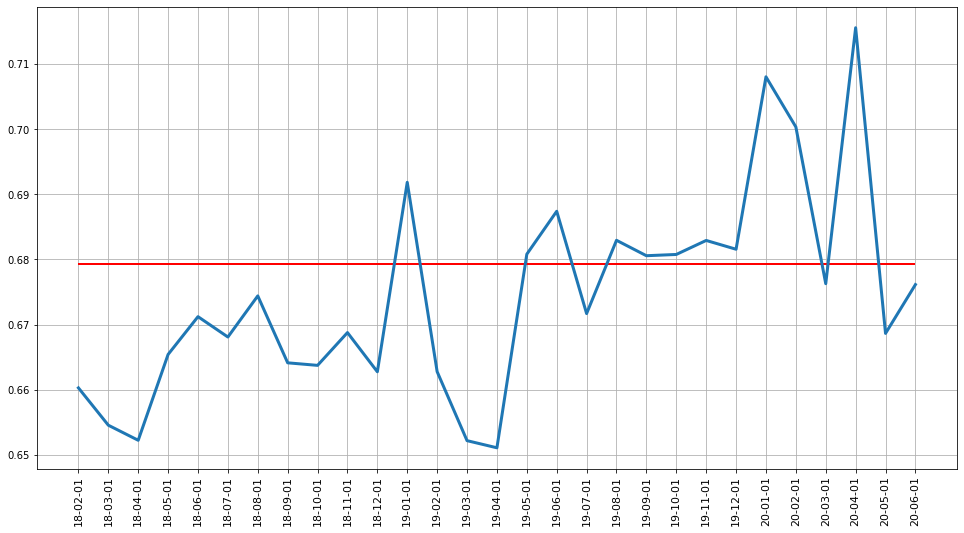

In [15]:
import matplotlib.pyplot as plt
import numpy as np

baseline = frame['Ref Acc'].values[0]
frame = frame.sort_values('Eval', axis=0)
fig = plt.figure()
fig.set_size_inches(16.5, 8.5)
ax = plt.axes()
x = list(range(frame.shape[0]))
labels = frame['Eval'].apply(lambda x: x[:8])

y = frame['Eval Acc'].values
plt.plot(x, y, '-', linewidth=3)
ax.hlines(y=baseline, xmin = 0, xmax = max(x), linewidth=2, color='r')

ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(labels.values, rotation='vertical', fontsize=11)

plt.grid()
plt.show()

In [5]:
import datapipeline.config as conf
import process_data
from datetime import datetime

def setup(date_from, date_to):
    config = conf.read_config('../delirium.conf')
    config.w = True
    config.r = True
    config.input = None
    config.output =  '/mnt/nfs/project/delirium/data/'
    config.filter_date_from = datetime.strptime(date_from, '%Y%m%d')
    config.filter_date_to = datetime.strptime(date_to, '%Y%m%d')
    config.split_column = ''
    return config

config = setup('20170101', '20171231')


ModuleNotFoundError: No module named 'process_data'

In [20]:
_, fp = process_data.pipeline(config)

postgresql://{config.user}:{config.password}@{config.host}:{config.port}/{config.database}
  patient_id   genc_id hospital_id  sex  age  mort_hosp discharge_date_time  \
0             11142603         SMH    1   85          0 2017-05-12 12:00:00   
1             11143029         SMH    1   66          0 2017-02-17 18:13:00   
2             11152407         SMH    1   84          0 2017-06-23 19:22:00   
3             11153607         SMH    0   30          0 2017-03-22 18:20:00   
4             11179938         SMH    1   73          0 2017-06-12 18:15:00   

      admit_date_time mr_diagnosis    year       los  readmission_7  \
0 2017-05-09 03:27:00         K922  2017.0  3.356250              0   
1 2017-02-15 00:43:00         I500  2017.0  2.729167              0   
2 2017-06-17 00:43:00         R296  2017.0  6.777083              0   
3 2017-03-16 18:41:00         T658  2017.0  5.985417              0   
4 2017-06-08 06:01:00         I633  2017.0  4.509722              0   

   read

In [21]:
print(fp)

/mnt/nfs/project/delirium/data/admin_data_2021-Nov-11_13-37-54.csv


In [22]:
import predict
args = predict.prepare_args()
args.input=fp
args.output = '../results_2017.csv'

predict.main(args)


{'config_file': None, 'user': 'koshkinam', 'password': 'Masha1978', 'port': 5432, 'host': 'db.gemini-hpc.ca', 'database': 'delirium_v3_0_0', 'output': '../', 'w': False, 'r': False, 'input': '../gemini_data.csv', 'features': ['hospital_id', 'sex', 'age', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'los_er', 'icd10_A00_B99', 'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99', 'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99', 'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99', 'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99', 'icd10_S00_T88', 'icd10_U07_U08', 'icd10_Z00_Z99', 'icd10_nan'], 'target': ['los'], 'pop_size': 10000, 'filter_year': 0, 'filter_date_from': '', 'filter_date_to': '', 'split_column': 'year', 'test': '2015', 'val': '2014', 'train': []}


In [23]:
def get_parameters_list(data):
    params  = data['params']
    return [params['model'], params['dataset']]


def get_metrics_list(data):
    if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        return [metrics['accuracy'], metrics['f1_score']]
    else:
        return ['-', '-']

exp = mlflow.get_experiment_by_name('Prediction')
runs = mlflow.list_run_infos(exp.experiment_id, max_results=100)
data = []
for r in runs:
    run_data = mlflow.get_run(r.run_id).to_dictionary()['data']
    row = [r.start_time] + get_metrics_list(run_data)
    data.append(row)
frame = pd.DataFrame(data, columns=['Start time', 'Accuracy', 'F1 Score'])
print('------------------- Prediction Runs ----------------------')
print(frame)

------------------- Prediction Runs ----------------------
       Start time  Accuracy F1 Score
0   1636655879972  0.686496  0.36008
1   1636655675204         -        -
2   1636655523155         -        -
3   1636655509416  0.677172   0.3558
4   1636654365228  0.677172   0.3558
5   1636654076196  0.677172   0.3558
6   1636653820861  0.677172   0.3558
7   1636653059262  0.677172   0.3558
8   1636652984160         -        -
9   1636651461303  0.677172   0.3558
10  1636651075742         -        -
11  1636650882207         -        -
12  1636650775411         -        -
13  1636650651927         -        -
14  1636650554974         -        -
15  1636650361188         -        -
16  1636650231133         -        -
17  1636650186765         -        -
18  1636650088458         -        -
19  1636649892598         -        -
20  1636649745337         -        -
21  1636649737253         -        -
22  1636649642056         -        -
23  1636649346380         -        -
24  163664702090

In [24]:
config = setup('20180101', '20181231')
_, fp = process_data.pipeline(config)
args = predict.prepare_args()
args.input=fp
args.output = '../results_2018.csv'

predict.main(args)

{'config_file': None, 'user': 'koshkinam', 'password': 'Masha1978', 'port': 5432, 'host': 'db.gemini-hpc.ca', 'database': 'delirium_v3_0_0', 'output': '/mnt/nfs/project/delirium/data/', 'w': False, 'r': False, 'input': '/mnt/nfs/project/delirium/data/all_before_2018.csv', 'features': ['hospital_id', 'sex', 'age', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'los_er', 'icd10_A00_B99', 'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99', 'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99', 'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99', 'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99', 'icd10_S00_T88', 'icd10_U07_U08', 'icd10_Z00_Z99', 'icd10_nan'], 'target': ['los'], 'pop_size': 0, 'filter_year': 2018, 'filter_date_from': '', 'filter_date_to': '', 'split_column': 'year', 'test': '0', 'val': '2018', 'train': []}
postgresql://{config.user}:{config.password}@{config.host}:{config.port}/{config.database}
  

In [1]:
import analysis
report_config = analysis.read_config()
report_config.type = 'performance'
report_config.reference = '../results_2017.csv'
report_config.test = '../results_2018.csv'
analysis.main(report_config)

In [2]:
report_config = analysis.read_config()
report_config.type = 'dataset'
report_config.input = '/mnt/nfs/project/delirium/data/all_before_2018.csv'
data_eval=[2018]
data_ref=[2017]
analysis.main(report_config)

dict_keys(['age', 'los_er', 'hospital_id', 'sex', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'icd10_A00_B99', 'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99', 'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99', 'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99', 'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99', 'icd10_S00_T88', 'icd10_Z00_Z99', 'los', 'n_features', 'n_drifted_features', 'share_drifted_features', 'dataset_drift'])
